In [15]:
import argparse
from itertools import product as iterprod
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from argparse import ArgumentParser
import time
from datetime import datetime
from tqdm.autonotebook import tqdm
import pandas as pd

import matplotlib.pyplot as plt



In [16]:
import utils.data67_processing as dp


from utils.UNeXt import UNet
from utils.loss_inference import loss_function_dict

import utils.nb_utils as nb_utils

import pprint

np.random.seed(11) # for reproducibility
torch.manual_seed(11)


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
batch_size = 4
num_workers = 2

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pin_memory = True if torch.cuda.is_available() else False

In [18]:
device


device(type='cuda', index=0)

# Build dataset

In [19]:
# Dataset
directory  = '/mnt/d/lding/FA/analysis_results/pFAK_zyxin_20230423/combined_npy_grouped_normalized/'

test_cells = 'cell_3'


in_channels  = [[6]] # Example: [[4], [4,6], [4,6,7]]. Channel 4 is mask, 6 is zyxin, 7 is other protein (here actin)
out_channels = (7)
transform_kwargs = {'crop_size': 512,
                    'output_channels': out_channels,
                    'norm_output': {'rescale': 1, 'threshold': 0.0004}
                    }

dataset_kwargs = { 
                    'root': directory,
                    'force_load': False,
                    'test_split': 'bycell',
                    'test_cells': test_cells,
                    'in_channels': in_channels, 
                    'out_channels': out_channels, 
                    'transform_kwargs': transform_kwargs,
                    'frames_to_keep': 256,
                    'input_baseline_normalization': 'none', # Comment on what these do
                    'output_baseline_normalization': 'none',
                    'remake_dataset_csv': True
                     }


dataset = dp.CellDataset( **dataset_kwargs )

train_loader = dataset.get_loader(dataset.train_indices, batch_size, num_workers, pin_memory)
validation_loader = dataset.get_loader(dataset.test_indices, batch_size, num_workers, pin_memory)

{'crop_size': 512, 'output_channels': 7, 'norm_output': {'rescale': 1, 'threshold': 0.0004}}


# Some visualizations of the training data

The dataset class gets items by looking into a dataframe (`dataset.info`) where the folders and filenames are stored. Folders correspond to single cells, and each file is a frame of the time series. 

`dataset.info` contains the normalization values which the data is normalized by before it is passed to the NN. Forces are normalized by `dataset.info.F_mean` and the zyxin signal is normalized by `dataset.info.zyxin_baseline_out` and `dataset.info.zyxin_baseline_in`. Details about how these are generated can be found in the DataProcessing notebook.
    


In [20]:
df = dataset.info.copy()

# df.head(10)

In [21]:
# Print test cells: 
print(dataset.test_cells)
print(dataset.test_indices)

{'test_cells': ['cell_3']}
[48 18 89 93 22 44 45  6 24 75 67 69 26  0  1 68 51 20 38 41 60 62 21  5
 33 59 50 28 35 25 82  9 39 88 46 90 85 16  3 12 63 15 40 14 61 17  4 49
 86 80 98]


In [22]:
# dataset.info

In [23]:
cell = 'cell_1'
frame = 10

idx = dataset.info.index[(dataset.info.folder==cell)&(dataset.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.
print(idx)

dataset.out_channels

sample = dataset[idx]

210


{'mask': torch.Size([1, 512, 512]), 'zyxin': torch.Size([1, 512, 512]), 'actin': torch.Size([1, 512, 512]), 'weight': torch.Size([1, 512, 512]), 'output': torch.Size([1, 512, 512])}


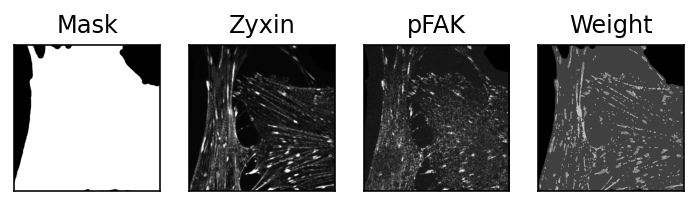

In [24]:
fig,ax=plt.subplots(1,4,figsize=(2*3, 4*2), dpi=144)

print({key: sample[key].shape for key in sample.keys()})

ax[0].set_title('Mask')
ax[0].imshow(sample['mask'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[1].set_title('Zyxin')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[2].set_title('pFAK')
ax[2].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[3].set_title('Weight')
ax[3].imshow(sample['weight'][0,:,:].squeeze(), origin='lower', cmap='gray', vmax=4, vmin=0)


for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

In [25]:
# sample['actin'].max()

In [26]:
# sample

### Build U-Net model with ConvNext blocks

In [27]:
n_lyr  = 3 # number of downsampling layers
ds_krnl= 4 # downsample kernel
n_ch   = 4 # number of channels in the beginning of the network
n_blocks = 4 # number of ConvNext blocks, wherever ConvNext blocks are used

prepend_hparams = {'start_channel': 1, 'resnet_channel': n_ch, 'end_channel': n_ch, 'N_blocks': n_blocks,                                         # Args for architecture
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} # Args for ConvNext blocks
encoder_hparams = {'n_ch': n_ch, 'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'N_skip_blocks': n_blocks,
                    'downsample_kwargs': {'kernel': ds_krnl, 'activation': 'gelu', 'batchnorm': 1},
                    'interlayer_kwargs': {'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
                    }
decoder_hparams = {'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'upsample_kernel': ds_krnl,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
append_hparams = {'start_channel': n_ch, 'resnet_channel': n_ch, 'end_channel': 1, 'N_blocks': n_blocks,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 8, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} 
optimizer_hparams = {'LR': 0.001, 'schedule_rate': 0.99}
loss_hparams = {'loss_type': 'aw_mse_corr',
                'exp_weight': 0.0,
                'strainenergy_regularization': 0.0,
                'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'loss_kwargs': {'max_force': 8.}
               }

n_epochs = 1000

modelname = 'protein1_datanormed_model_zyxin2pfak_aw_mse_corr_'+str(n_epochs)+'ep'

logger_params = {'log_dir': f'./tensorboard_logs/{modelname}', 
                    'image_epoch_freq': 10,
                    'image_callbacks': 'vectorfield,hists',
                    'save_model_freq': 4}

# Actually build model:
model_kwargs={
                'input_type':  'zyxin', 
                'prepend_hparams': prepend_hparams, 
                'encoder_hparams': encoder_hparams, 
                'decoder_hparams': decoder_hparams, 
                'append_hparams': append_hparams, 
                'optimizer_hparams': optimizer_hparams,
                'loss_hparams': loss_hparams,
                'logger_params': logger_params,
                'name': modelname}


model = UNet( **model_kwargs, model_idx=0)
model.to(device)


UNet(
  (layers_encode): ModuleList(
    (0): ModuleList(
      (0-3): 4 x ConvNextCell(
        (conv0): Conv2d(4, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=4)
        (conv1): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): GELU(approximate='none')
      )
      (4): DownsampleLayer(
        (conv): Conv2d(4, 8, kernel_size=(4, 4), stride=(4, 4))
        (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): GELU(approximate='none')
      )
    )
    (1): ModuleList(
      (0-3): 4 x ConvNextCell(
        (conv0): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=8)
        (conv1): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(8, eps=

# Perform training

In [28]:
save_models = True

pbar = tqdm(total=n_epochs*(np.minimum(dataset.frames_to_keep, len(dataset.train_indices))/batch_size))

t0 = time.time()
for e in range(n_epochs):
    pbar.set_description(f'Epoch {e}')
    loss_values_train = {}
    loss_values_val = {}

    model.reset_running_train_loss()
    model.reset_running_val_loss()

    for sample in train_loader: 
        for key in sample:
            sample[key] = sample[key].to(device)
        
        model.training_step(sample, epoch=e) # loss.backward() and optimizer step occur in here
        
        pbar.update(1)

    for sample in validation_loader:
        for key in sample:
            sample[key] = sample[key].to(device)     
    
        model.validation_step(sample, epoch=e)

    model.scheduler.step()    
    print("Epoch %u:\t Time: %0.2f \t(per epoch: %0.2f), loss=%0.3f"%(e, time.time()-t0, (time.time()-t0)/(e+1),model.get_running_val_loss()['aw_mse_corr_loss']))
    
    # SAVE
    if save_models:
        # Log in tensorboard
        model.log_scalars(epoch=e) 
            
        # Save models
        if e%(logger_params['save_model_freq'])==0 or e==n_epochs-1: 
            torch.save({'model': model.state_dict(),
                        'model_kwargs': model_kwargs,
                        'model_name': model.name,
                        'model_idx': model.index,
                        'dataset_kwargs': dataset_kwargs,
                        'test_cells': dataset.test_cells,
                        }, 
                       os.path.join( model.logdir, 'model.pt') )


Epoch 0:   0%|          | 44/19200.0 [00:48<5:52:19,  1.10s/it]


Epoch 0:	 Time: 45.89 	(per epoch: 45.89), loss=5.425


Epoch 1:	 Time: 93.15 	(per epoch: 46.58), loss=7.290


Epoch 2:	 Time: 138.38 	(per epoch: 46.13), loss=4.107


Epoch 3:	 Time: 184.13 	(per epoch: 46.03), loss=5.905


Epoch 4:	 Time: 231.42 	(per epoch: 46.28), loss=3.762


Epoch 5:	 Time: 277.55 	(per epoch: 46.26), loss=3.243


Epoch 6:	 Time: 323.83 	(per epoch: 46.26), loss=3.453


Epoch 7:	 Time: 370.00 	(per epoch: 46.25), loss=3.397


Epoch 8:	 Time: 415.80 	(per epoch: 46.20), loss=4.163


Epoch 9:	 Time: 461.12 	(per epoch: 46.11), loss=3.189


Epoch 10:	 Time: 506.79 	(per epoch: 46.07), loss=4.456


Epoch 11:	 Time: 552.36 	(per epoch: 46.03), loss=3.204


Epoch 12:	 Time: 597.69 	(per epoch: 45.98), loss=2.813


Epoch 13:	 Time: 643.08 	(per epoch: 45.93), loss=3.760


Epoch 14:	 Time: 688.40 	(per epoch: 45.89), loss=3.109


Epoch 15:	 Time: 733.48 	(per epoch: 45.84), loss=3.056


Epoch 16:	 Time: 778.79 	(per epoch: 45.81), loss=2.975


Epoch 17:	 Time: 823.89 	(per epoch: 45.77), loss=2.921


Epoch 18:	 Time: 869.04 	(per epoch: 45.74), loss=3.049


Epoch 19:	 Time: 914.66 	(per epoch: 45.73), loss=2.739


Epoch 20:	 Time: 959.72 	(per epoch: 45.70), loss=3.251


Epoch 21:	 Time: 1005.12 	(per epoch: 45.69), loss=2.629


Epoch 22:	 Time: 1050.09 	(per epoch: 45.66), loss=3.081


Epoch 23:	 Time: 1095.48 	(per epoch: 45.64), loss=3.072


Epoch 24:	 Time: 1140.69 	(per epoch: 45.63), loss=3.162


Epoch 25:	 Time: 1185.96 	(per epoch: 45.61), loss=2.638


Epoch 26:	 Time: 1231.56 	(per epoch: 45.61), loss=2.891


Epoch 27:	 Time: 1277.13 	(per epoch: 45.61), loss=3.069


Epoch 28:	 Time: 1322.45 	(per epoch: 45.60), loss=3.225


Epoch 29:	 Time: 1368.04 	(per epoch: 45.60), loss=3.310


Epoch 30:	 Time: 1413.82 	(per epoch: 45.61), loss=3.475


Epoch 31:	 Time: 1459.61 	(per epoch: 45.61), loss=2.776


Epoch 32:	 Time: 1505.39 	(per epoch: 45.62), loss=3.359


Epoch 33:	 Time: 1550.75 	(per epoch: 45.61), loss=2.932


Epoch 34:	 Time: 1596.08 	(per epoch: 45.60), loss=2.908


Epoch 35:	 Time: 1641.68 	(per epoch: 45.60), loss=2.644


Epoch 36:	 Time: 1687.09 	(per epoch: 45.60), loss=2.591


Epoch 37:	 Time: 1732.95 	(per epoch: 45.60), loss=2.735


Epoch 38:	 Time: 1778.94 	(per epoch: 45.61), loss=2.584


Epoch 39:	 Time: 1824.88 	(per epoch: 45.62), loss=2.931


Epoch 40:	 Time: 1870.92 	(per epoch: 45.63), loss=3.053


Epoch 41:	 Time: 1917.27 	(per epoch: 45.65), loss=2.942


Epoch 42:	 Time: 1963.19 	(per epoch: 45.66), loss=2.692


Epoch 43:	 Time: 2008.74 	(per epoch: 45.65), loss=2.945


Epoch 44:	 Time: 2054.18 	(per epoch: 45.65), loss=2.928


Epoch 45:	 Time: 2100.26 	(per epoch: 45.66), loss=2.624


Epoch 46:	 Time: 2146.20 	(per epoch: 45.66), loss=2.565


Epoch 47:	 Time: 2192.16 	(per epoch: 45.67), loss=2.663


Epoch 48:	 Time: 2237.65 	(per epoch: 45.67), loss=2.588


Epoch 49:	 Time: 2283.61 	(per epoch: 45.67), loss=2.717


Epoch 50:	 Time: 2329.65 	(per epoch: 45.68), loss=2.792


Epoch 51:	 Time: 2375.49 	(per epoch: 45.68), loss=2.587


Epoch 52:	 Time: 2421.05 	(per epoch: 45.68), loss=2.621


Epoch 53:	 Time: 2466.84 	(per epoch: 45.68), loss=2.840


Epoch 54:	 Time: 2512.20 	(per epoch: 45.68), loss=2.640


Epoch 55:	 Time: 2557.42 	(per epoch: 45.67), loss=2.894


Epoch 56:	 Time: 2602.65 	(per epoch: 45.66), loss=2.863


Epoch 57:	 Time: 2647.95 	(per epoch: 45.65), loss=2.601


Epoch 58:	 Time: 2693.28 	(per epoch: 45.65), loss=2.632


Epoch 59:	 Time: 2738.56 	(per epoch: 45.64), loss=2.839


Epoch 60:	 Time: 2784.06 	(per epoch: 45.64), loss=2.774


Epoch 61:	 Time: 2829.38 	(per epoch: 45.64), loss=2.814


Epoch 62:	 Time: 2874.76 	(per epoch: 45.63), loss=2.580


Epoch 63:	 Time: 2920.32 	(per epoch: 45.63), loss=2.803


Epoch 64:	 Time: 2965.46 	(per epoch: 45.62), loss=2.833


Epoch 65:	 Time: 3011.05 	(per epoch: 45.62), loss=2.719


Epoch 66:	 Time: 3057.01 	(per epoch: 45.63), loss=2.795


Epoch 67:	 Time: 3102.64 	(per epoch: 45.63), loss=2.407


Epoch 68:	 Time: 3148.41 	(per epoch: 45.63), loss=2.949


Epoch 69:	 Time: 3194.52 	(per epoch: 45.64), loss=2.412


Epoch 70:	 Time: 3241.08 	(per epoch: 45.65), loss=2.541


Epoch 71:	 Time: 3287.19 	(per epoch: 45.66), loss=2.484


Epoch 72:	 Time: 3332.91 	(per epoch: 45.66), loss=2.803


Epoch 73:	 Time: 3378.93 	(per epoch: 45.66), loss=2.385


Epoch 74:	 Time: 3425.14 	(per epoch: 45.67), loss=2.696


Epoch 75:	 Time: 3471.08 	(per epoch: 45.67), loss=2.660


Epoch 76:	 Time: 3516.43 	(per epoch: 45.67), loss=2.563


Epoch 77:	 Time: 3562.17 	(per epoch: 45.67), loss=2.666


Epoch 78:	 Time: 3607.97 	(per epoch: 45.67), loss=2.579


Epoch 79:	 Time: 3655.00 	(per epoch: 45.69), loss=2.559


Epoch 80:	 Time: 3701.55 	(per epoch: 45.70), loss=2.688


Epoch 81:	 Time: 3747.43 	(per epoch: 45.70), loss=2.483


Epoch 82:	 Time: 3793.42 	(per epoch: 45.70), loss=2.638


Epoch 83:	 Time: 3839.31 	(per epoch: 45.71), loss=2.338


Epoch 84:	 Time: 3885.55 	(per epoch: 45.71), loss=2.605


Epoch 85:	 Time: 3931.25 	(per epoch: 45.71), loss=2.661


Epoch 86:	 Time: 3976.90 	(per epoch: 45.71), loss=2.498


Epoch 87:	 Time: 4023.10 	(per epoch: 45.72), loss=2.679


Epoch 88:	 Time: 4068.88 	(per epoch: 45.72), loss=2.637


Epoch 89:	 Time: 4114.80 	(per epoch: 45.72), loss=2.730


Epoch 90:	 Time: 4160.15 	(per epoch: 45.72), loss=2.470


Epoch 91:	 Time: 4205.55 	(per epoch: 45.71), loss=2.592


Epoch 92:	 Time: 4250.80 	(per epoch: 45.71), loss=2.628


Epoch 93:	 Time: 4296.04 	(per epoch: 45.70), loss=2.665


Epoch 94:	 Time: 4341.26 	(per epoch: 45.70), loss=2.508


Epoch 95:	 Time: 4386.16 	(per epoch: 45.69), loss=2.365


Epoch 96:	 Time: 4431.32 	(per epoch: 45.68), loss=2.626


Epoch 97:	 Time: 4476.47 	(per epoch: 45.68), loss=2.559


Epoch 98:	 Time: 4521.75 	(per epoch: 45.67), loss=2.593


Epoch 99:	 Time: 4567.11 	(per epoch: 45.67), loss=2.704


Epoch 100:	 Time: 4612.29 	(per epoch: 45.67), loss=2.798


Epoch 101:	 Time: 4657.54 	(per epoch: 45.66), loss=2.331


Epoch 102:	 Time: 4703.06 	(per epoch: 45.66), loss=2.501


Epoch 103:	 Time: 4748.44 	(per epoch: 45.66), loss=2.746


Epoch 104:	 Time: 4793.94 	(per epoch: 45.66), loss=2.676


Epoch 105:	 Time: 4839.26 	(per epoch: 45.65), loss=2.455


Epoch 106:	 Time: 4885.05 	(per epoch: 45.65), loss=2.522


Epoch 107:	 Time: 4930.84 	(per epoch: 45.66), loss=2.464


Epoch 108:	 Time: 4976.52 	(per epoch: 45.66), loss=2.562


Epoch 109:	 Time: 5022.28 	(per epoch: 45.66), loss=2.499


Epoch 110:	 Time: 5067.99 	(per epoch: 45.66), loss=2.513


Epoch 111:	 Time: 5113.89 	(per epoch: 45.66), loss=2.291


Epoch 112:	 Time: 5159.58 	(per epoch: 45.66), loss=2.387


Epoch 113:	 Time: 5205.33 	(per epoch: 45.66), loss=2.628


Epoch 114:	 Time: 5250.92 	(per epoch: 45.66), loss=2.701


Epoch 115:	 Time: 5296.32 	(per epoch: 45.66), loss=2.437


Epoch 116:	 Time: 5342.29 	(per epoch: 45.66), loss=2.424


Epoch 117:	 Time: 5388.18 	(per epoch: 45.66), loss=2.623


Epoch 118:	 Time: 5434.00 	(per epoch: 45.66), loss=2.456


Epoch 119:	 Time: 5479.77 	(per epoch: 45.66), loss=2.592


Epoch 120:	 Time: 5525.50 	(per epoch: 45.67), loss=2.535


Epoch 121:	 Time: 5571.37 	(per epoch: 45.67), loss=2.681


Epoch 122:	 Time: 5617.29 	(per epoch: 45.67), loss=2.561


Epoch 123:	 Time: 5662.82 	(per epoch: 45.67), loss=2.550


Epoch 124:	 Time: 5708.78 	(per epoch: 45.67), loss=2.913


Epoch 125:	 Time: 5754.60 	(per epoch: 45.67), loss=2.385


Epoch 126:	 Time: 5800.46 	(per epoch: 45.67), loss=2.628


Epoch 127:	 Time: 5845.81 	(per epoch: 45.67), loss=2.413


Epoch 128:	 Time: 5891.82 	(per epoch: 45.67), loss=2.449


Epoch 129:	 Time: 5938.04 	(per epoch: 45.68), loss=2.430


Epoch 130:	 Time: 5984.13 	(per epoch: 45.68), loss=2.549


Epoch 131:	 Time: 6030.30 	(per epoch: 45.68), loss=2.685


Epoch 132:	 Time: 6076.44 	(per epoch: 45.69), loss=2.885


Epoch 133:	 Time: 6122.39 	(per epoch: 45.69), loss=2.444


Epoch 134:	 Time: 6167.91 	(per epoch: 45.69), loss=2.535


Epoch 135:	 Time: 6213.20 	(per epoch: 45.69), loss=2.408


Epoch 136:	 Time: 6258.27 	(per epoch: 45.68), loss=2.538


Epoch 137:	 Time: 6303.24 	(per epoch: 45.68), loss=2.617


Epoch 138:	 Time: 6348.44 	(per epoch: 45.67), loss=2.535


Epoch 139:	 Time: 6393.42 	(per epoch: 45.67), loss=2.635


Epoch 140:	 Time: 6438.55 	(per epoch: 45.66), loss=2.490


Epoch 141:	 Time: 6483.84 	(per epoch: 45.66), loss=2.493


Epoch 142:	 Time: 6528.96 	(per epoch: 45.66), loss=2.604


Epoch 143:	 Time: 6574.29 	(per epoch: 45.65), loss=2.906


Epoch 144:	 Time: 6619.42 	(per epoch: 45.65), loss=2.540


Epoch 145:	 Time: 6665.12 	(per epoch: 45.65), loss=2.147


Epoch 146:	 Time: 6710.72 	(per epoch: 45.65), loss=2.664


Epoch 147:	 Time: 6756.40 	(per epoch: 45.65), loss=2.448


Epoch 148:	 Time: 6802.39 	(per epoch: 45.65), loss=2.590


Epoch 149:	 Time: 6848.21 	(per epoch: 45.65), loss=2.391


Epoch 150:	 Time: 6894.04 	(per epoch: 45.66), loss=2.292


Epoch 151:	 Time: 6940.11 	(per epoch: 45.66), loss=2.502


Epoch 152:	 Time: 6986.01 	(per epoch: 45.66), loss=2.732


Epoch 153:	 Time: 7031.40 	(per epoch: 45.66), loss=2.521


Epoch 154:	 Time: 7077.05 	(per epoch: 45.66), loss=2.778


Epoch 155:	 Time: 7122.84 	(per epoch: 45.66), loss=2.590


Epoch 156:	 Time: 7168.50 	(per epoch: 45.66), loss=2.669


Epoch 157:	 Time: 7214.24 	(per epoch: 45.66), loss=2.714


Epoch 158:	 Time: 7260.12 	(per epoch: 45.66), loss=2.516


Epoch 159:	 Time: 7306.34 	(per epoch: 45.66), loss=2.441


Epoch 160:	 Time: 7352.40 	(per epoch: 45.67), loss=2.408


Epoch 161:	 Time: 7398.07 	(per epoch: 45.67), loss=2.490


Epoch 162:	 Time: 7444.08 	(per epoch: 45.67), loss=2.555


Epoch 163:	 Time: 7489.77 	(per epoch: 45.67), loss=2.521


Epoch 164:	 Time: 7535.59 	(per epoch: 45.67), loss=2.283


Epoch 165:	 Time: 7581.64 	(per epoch: 45.67), loss=2.206


Epoch 166:	 Time: 7627.55 	(per epoch: 45.67), loss=2.504


Epoch 167:	 Time: 7673.60 	(per epoch: 45.68), loss=2.575


Epoch 168:	 Time: 7720.09 	(per epoch: 45.68), loss=2.470


Epoch 169:	 Time: 7767.52 	(per epoch: 45.69), loss=2.566


Epoch 170:	 Time: 7815.18 	(per epoch: 45.70), loss=2.427


Epoch 171:	 Time: 7862.40 	(per epoch: 45.71), loss=2.297


Epoch 172:	 Time: 7910.28 	(per epoch: 45.72), loss=2.398


Epoch 173:	 Time: 7958.32 	(per epoch: 45.74), loss=2.508


Epoch 174:	 Time: 8006.00 	(per epoch: 45.75), loss=2.468


Epoch 175:	 Time: 8053.46 	(per epoch: 45.76), loss=2.554


Epoch 176:	 Time: 8102.67 	(per epoch: 45.78), loss=2.465


Epoch 177:	 Time: 8159.60 	(per epoch: 45.84), loss=2.424


Epoch 178:	 Time: 8205.47 	(per epoch: 45.84), loss=2.442


Epoch 179:	 Time: 8250.86 	(per epoch: 45.84), loss=2.464


Epoch 180:	 Time: 8296.60 	(per epoch: 45.84), loss=2.475


Epoch 181:	 Time: 8341.82 	(per epoch: 45.83), loss=2.678


Epoch 182:	 Time: 8387.00 	(per epoch: 45.83), loss=2.265


Epoch 183:	 Time: 8432.24 	(per epoch: 45.83), loss=2.650


Epoch 184:	 Time: 8477.46 	(per epoch: 45.82), loss=2.498


Epoch 185:	 Time: 8523.30 	(per epoch: 45.82), loss=2.721


Epoch 186:	 Time: 8568.86 	(per epoch: 45.82), loss=2.530


Epoch 187:	 Time: 8614.78 	(per epoch: 45.82), loss=2.501


Epoch 188:	 Time: 8660.57 	(per epoch: 45.82), loss=2.611


Epoch 189:	 Time: 8706.41 	(per epoch: 45.82), loss=2.403


Epoch 190:	 Time: 8751.92 	(per epoch: 45.82), loss=2.683


Epoch 191:	 Time: 8797.27 	(per epoch: 45.82), loss=2.468


Epoch 192:	 Time: 8842.65 	(per epoch: 45.82), loss=2.815


Epoch 193:	 Time: 8888.61 	(per epoch: 45.82), loss=2.878


Epoch 194:	 Time: 8934.02 	(per epoch: 45.82), loss=2.496


Epoch 195:	 Time: 8979.94 	(per epoch: 45.82), loss=2.393


Epoch 196:	 Time: 9025.32 	(per epoch: 45.81), loss=2.510


Epoch 197:	 Time: 9070.70 	(per epoch: 45.81), loss=2.287


Epoch 198:	 Time: 9115.97 	(per epoch: 45.81), loss=2.716


Epoch 199:	 Time: 9161.21 	(per epoch: 45.81), loss=2.580


Epoch 200:	 Time: 9206.81 	(per epoch: 45.81), loss=2.448


Epoch 201:	 Time: 9252.71 	(per epoch: 45.81), loss=2.727


Epoch 202:	 Time: 9298.09 	(per epoch: 45.80), loss=2.650


Epoch 203:	 Time: 9343.31 	(per epoch: 45.80), loss=2.543


Epoch 204:	 Time: 9388.90 	(per epoch: 45.80), loss=2.507


Epoch 205:	 Time: 9434.45 	(per epoch: 45.80), loss=2.701


Epoch 206:	 Time: 9479.90 	(per epoch: 45.80), loss=2.548


Epoch 207:	 Time: 9525.82 	(per epoch: 45.80), loss=2.480


Epoch 208:	 Time: 9571.53 	(per epoch: 45.80), loss=2.563


Epoch 209:	 Time: 9617.07 	(per epoch: 45.80), loss=2.771


Epoch 210:	 Time: 9662.97 	(per epoch: 45.80), loss=2.774


Epoch 211:	 Time: 9708.33 	(per epoch: 45.79), loss=2.430


Epoch 212:	 Time: 9753.40 	(per epoch: 45.79), loss=2.461


Epoch 213:	 Time: 9798.58 	(per epoch: 45.79), loss=2.591


Epoch 214:	 Time: 9844.14 	(per epoch: 45.79), loss=2.674


Epoch 215:	 Time: 9889.67 	(per epoch: 45.79), loss=2.507


Epoch 216:	 Time: 9934.69 	(per epoch: 45.78), loss=2.592


Epoch 217:	 Time: 9979.77 	(per epoch: 45.78), loss=2.641


Epoch 218:	 Time: 10024.97 	(per epoch: 45.78), loss=2.561


Epoch 219:	 Time: 10069.96 	(per epoch: 45.77), loss=2.613


Epoch 220:	 Time: 10114.71 	(per epoch: 45.77), loss=2.327


Epoch 221:	 Time: 10159.72 	(per epoch: 45.76), loss=2.437


Epoch 222:	 Time: 10204.38 	(per epoch: 45.76), loss=2.480


Epoch 223:	 Time: 10249.15 	(per epoch: 45.76), loss=2.444


Epoch 224:	 Time: 10294.24 	(per epoch: 45.75), loss=2.510


Epoch 225:	 Time: 10339.31 	(per epoch: 45.75), loss=2.476


Epoch 226:	 Time: 10384.25 	(per epoch: 45.75), loss=2.431


Epoch 227:	 Time: 10429.78 	(per epoch: 45.74), loss=2.524


Epoch 228:	 Time: 10474.73 	(per epoch: 45.74), loss=2.356


Epoch 229:	 Time: 10519.93 	(per epoch: 45.74), loss=2.516


Epoch 230:	 Time: 10565.18 	(per epoch: 45.74), loss=2.682


Epoch 231:	 Time: 10610.76 	(per epoch: 45.74), loss=2.463


Epoch 232:	 Time: 10656.21 	(per epoch: 45.73), loss=2.568


Epoch 233:	 Time: 10701.56 	(per epoch: 45.73), loss=2.337


Epoch 234:	 Time: 10747.06 	(per epoch: 45.73), loss=2.393


Epoch 235:	 Time: 10792.29 	(per epoch: 45.73), loss=2.577


Epoch 236:	 Time: 10837.78 	(per epoch: 45.73), loss=2.611


Epoch 237:	 Time: 10883.10 	(per epoch: 45.73), loss=2.384


Epoch 238:	 Time: 10928.35 	(per epoch: 45.73), loss=2.591


Epoch 239:	 Time: 10973.96 	(per epoch: 45.72), loss=2.627


Epoch 240:	 Time: 11019.51 	(per epoch: 45.72), loss=2.259


Epoch 241:	 Time: 11064.99 	(per epoch: 45.72), loss=2.542


Epoch 242:	 Time: 11110.64 	(per epoch: 45.72), loss=2.654


Epoch 243:	 Time: 11156.11 	(per epoch: 45.72), loss=2.358


Epoch 244:	 Time: 11201.28 	(per epoch: 45.72), loss=2.314


Epoch 245:	 Time: 11246.59 	(per epoch: 45.72), loss=2.393


Epoch 246:	 Time: 11291.99 	(per epoch: 45.72), loss=2.471


Epoch 247:	 Time: 11337.64 	(per epoch: 45.72), loss=2.628


Epoch 248:	 Time: 11383.03 	(per epoch: 45.71), loss=2.249


Epoch 249:	 Time: 11428.46 	(per epoch: 45.71), loss=2.480


Epoch 250:	 Time: 11473.68 	(per epoch: 45.71), loss=2.446


Epoch 251:	 Time: 11519.12 	(per epoch: 45.71), loss=2.426


Epoch 252:	 Time: 11564.42 	(per epoch: 45.71), loss=2.723


Epoch 253:	 Time: 11610.01 	(per epoch: 45.71), loss=2.195


Epoch 254:	 Time: 11655.26 	(per epoch: 45.71), loss=2.380


Epoch 255:	 Time: 11700.98 	(per epoch: 45.71), loss=2.737


Epoch 256:	 Time: 11748.70 	(per epoch: 45.71), loss=2.754


Epoch 257:	 Time: 11795.43 	(per epoch: 45.72), loss=2.313


Epoch 258:	 Time: 11840.91 	(per epoch: 45.72), loss=2.635


Epoch 259:	 Time: 11886.22 	(per epoch: 45.72), loss=2.274


Epoch 260:	 Time: 11931.19 	(per epoch: 45.71), loss=2.690


Epoch 261:	 Time: 11976.48 	(per epoch: 45.71), loss=2.657


Epoch 262:	 Time: 12021.72 	(per epoch: 45.71), loss=2.540


Epoch 263:	 Time: 12066.81 	(per epoch: 45.71), loss=2.555


Epoch 264:	 Time: 12111.96 	(per epoch: 45.71), loss=2.223


Epoch 265:	 Time: 12157.57 	(per epoch: 45.71), loss=2.814


Epoch 266:	 Time: 12203.33 	(per epoch: 45.71), loss=2.487


Epoch 267:	 Time: 12248.81 	(per epoch: 45.70), loss=2.696


Epoch 268:	 Time: 12294.34 	(per epoch: 45.70), loss=2.374


Epoch 269:	 Time: 12339.75 	(per epoch: 45.70), loss=2.573


Epoch 270:	 Time: 12385.41 	(per epoch: 45.70), loss=2.554


Epoch 271:	 Time: 12430.87 	(per epoch: 45.70), loss=2.343


Epoch 272:	 Time: 12476.26 	(per epoch: 45.70), loss=2.534


Epoch 273:	 Time: 12521.51 	(per epoch: 45.70), loss=2.717


Epoch 274:	 Time: 12566.53 	(per epoch: 45.70), loss=2.428


Epoch 275:	 Time: 12612.01 	(per epoch: 45.70), loss=2.538


Epoch 276:	 Time: 12657.41 	(per epoch: 45.69), loss=2.288


Epoch 277:	 Time: 12702.74 	(per epoch: 45.69), loss=2.533


Epoch 278:	 Time: 12748.30 	(per epoch: 45.69), loss=2.546


Epoch 279:	 Time: 12793.93 	(per epoch: 45.69), loss=2.422


Epoch 280:	 Time: 12839.52 	(per epoch: 45.69), loss=2.459


Epoch 281:	 Time: 12885.32 	(per epoch: 45.69), loss=2.573


Epoch 282:	 Time: 12930.75 	(per epoch: 45.69), loss=2.631


Epoch 283:	 Time: 12976.40 	(per epoch: 45.69), loss=2.507


Epoch 284:	 Time: 13022.02 	(per epoch: 45.69), loss=2.484


Epoch 285:	 Time: 13067.60 	(per epoch: 45.69), loss=2.365


Epoch 286:	 Time: 13113.55 	(per epoch: 45.69), loss=2.246


Epoch 287:	 Time: 13159.23 	(per epoch: 45.69), loss=2.486


Epoch 288:	 Time: 13205.19 	(per epoch: 45.69), loss=2.402


Epoch 289:	 Time: 13251.23 	(per epoch: 45.69), loss=2.411


Epoch 290:	 Time: 13297.08 	(per epoch: 45.69), loss=2.376


Epoch 291:	 Time: 13343.03 	(per epoch: 45.70), loss=2.475


Epoch 292:	 Time: 13389.06 	(per epoch: 45.70), loss=2.565


Epoch 293:	 Time: 13434.52 	(per epoch: 45.70), loss=2.515


Epoch 294:	 Time: 13480.53 	(per epoch: 45.70), loss=2.548


Epoch 295:	 Time: 13525.99 	(per epoch: 45.70), loss=2.466


Epoch 296:	 Time: 13571.73 	(per epoch: 45.70), loss=2.291


Epoch 297:	 Time: 13617.39 	(per epoch: 45.70), loss=2.653


Epoch 298:	 Time: 13663.08 	(per epoch: 45.70), loss=2.652


Epoch 299:	 Time: 13708.68 	(per epoch: 45.70), loss=2.671


In [29]:
sample['actin'].sum

<function Tensor.sum>

### Plot prediction on train cell

In [30]:
def normcorr(input1,input2):
    input1_0_mean = input1 - np.mean(input1)
    input2_0_mean = input2 - np.mean(input2)
    corr = np.mean(input1_0_mean * input2_0_mean)
    corr_norm = corr/np.std(input1_0_mean)/np.std(input2_0_mean)
    return corr_norm


In [31]:
import tifffile
from utils.data67_processing import CellDataset, SubsetSampler

prediction_result_folder = '../zyxin2pfak_results/'

if not os.path.isdir(prediction_result_folder):          
    os.mkdir(prediction_result_folder)

model_prediction_result_folder = '../zyxin2pfak_results/' +modelname + '/'

if not os.path.isdir(model_prediction_result_folder):          
    os.mkdir(model_prediction_result_folder)


plot_result_folder = model_prediction_result_folder +'plot'
tiff_result_folder = model_prediction_result_folder +'tiff'

if not os.path.isdir(plot_result_folder):          
    os.mkdir(plot_result_folder)

if not os.path.isdir(tiff_result_folder):          
    os.mkdir(tiff_result_folder)


eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 1024
eval_dataset_kwargs['exclude_frames'] = None
dataset = dp.CellDataset( **eval_dataset_kwargs )

sampler = SubsetSampler(np.arange(len(dataset)))
loader = torch.utils.data.DataLoader(dataset, 
    batch_size=1,
    shuffle=False,
    sampler=sampler,
    pin_memory=True)




pred_corr_df = pd.DataFrame(columns=['cell_ID', 'time_point', 'train_test', 'coor_zyxin_pfak','coor_zyxin_nnpfak','coor_pfak_nnpfak'])


for cell in ['cell_1','cell_2','cell_3','cell_4','cell_5','cell_6']:
    for frame in range(100):  

        idx = np.sort(dataset.info[dataset.info.folder==cell].index.values)
        idx = idx[frame]

        model.eval()
        model.to(torch.device('cuda:0'))

        sample = dataset[idx]
        for k in sample:
            sample[k] = sample[k].unsqueeze(0).to(torch.device('cuda:0'))

        preds = []
        for _ in range(5):
            pred = model(model.select_inputs(model.input_type, sample)).detach().cpu().numpy().squeeze()
            preds.append(pred)
            
        pred = np.mean(preds, axis=0) 
        target = sample['output'].detach().cpu().numpy().squeeze() 
        zyx = sample['zyxin'].detach().cpu().numpy().squeeze()
        pax = sample['actin'].detach().cpu().numpy().squeeze()
        mask= sample['mask'].detach().cpu().numpy().squeeze()

        from skimage.morphology import square, dilation
        dilate_mask = dilation(mask, square(64))>0

        zyxin_values = zyx[dilate_mask>0]
        pfak_values = pax[dilate_mask>0]
        nn_values = pred.squeeze()[dilate_mask>0]


        z_p_corr = normcorr(zyxin_values,pfak_values)
        z_n_corr = normcorr(zyxin_values,nn_values)
        p_n_corr = normcorr(pfak_values,nn_values)
        z_z_corr = normcorr(zyxin_values,zyxin_values)
        p_p_corr = normcorr(pfak_values,pfak_values)
        
        train_test_flag= 'train'
        if cell == 'cell_3' or cell == 'cell_6' :
            train_test_flag= 'test'

        s = pd.Series([cell, frame, train_test_flag,z_p_corr,z_n_corr,p_n_corr],
                        index=['cell_ID', 'time_point', 'train_test', 'coor_zyxin_pfak','coor_zyxin_nnpfak','coor_pfak_nnpfak'])
        pred_corr_df = pred_corr_df._append(s,ignore_index=True)

        pred_corr_df.to_csv(os.path.join(model_prediction_result_folder,modelname+'z2p_prediction_300epochs_corr.csv'))

        fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

        ax[0].set_title('Zyxin')
        ax[0].imshow(zyx,  cmap='gray', vmax=1, vmin=0)
        if cell == 'cell_3' or cell == 'cell_6' :
            ax[0].set_xlabel('Testing set: ' + cell)
        else:
            ax[0].set_xlabel('Training set: ' + cell)
            
            
        ax[1].set_title('pFAK-Exp')
        ax[1].imshow(pax, cmap='gray', vmax=1, vmin=0)
        ax[1].set_xlabel('Frame '+ str(frame))
        
        ax[2].set_title('pFAK-NN')
        ax[2].imshow(pred.squeeze()*dilate_mask,  cmap='gray', vmax=1, vmin=0)
        ax[2].set_xlabel('zp'+ "%.2f" % (z_p_corr) +',zn'+ "%.2f" % (z_n_corr) +',pn'+ "%.2f" % (p_n_corr))#+',zz'+ "%.2f" % (z_z_corr)+',pp'+ "%.2f" % (p_p_corr))

        tifffile.imsave(os.path.join(tiff_result_folder,cell + '_frame'+str(frame)+'.tif'),pred.squeeze()[0]/5)
        
        for a in ax.flat:
            a.set_xticks([])
            a.set_yticks([])
                    
        fig.savefig(os.path.join(plot_result_folder, cell + '_frame'+str(frame)+'.png'))
        plt.close(fig) 


{'crop_size': 1024, 'output_channels': 7, 'norm_output': {'rescale': 1, 'threshold': 0.0004}}


In [32]:
model(model.select_inputs(model.input_type, sample)).shape

torch.Size([1, 1, 1024, 1024])

In [ ]:
zyxin_values = zyx[dilate_mask>0]
pfak_values = pax[dilate_mask>0]
nn_values = pred[dilate_mask>0]

In [ ]:
np.mean(zyxin_values)

In [ ]:
pax.mean()

{'crop_size': 960, 'output_channels': 7, 'norm_output': {'rescale': 1, 'threshold': 0.0004}}
torch.Size([1, 1, 960, 960])
(1, 1, 960, 960)


TypeError: Invalid shape (960,) for image data

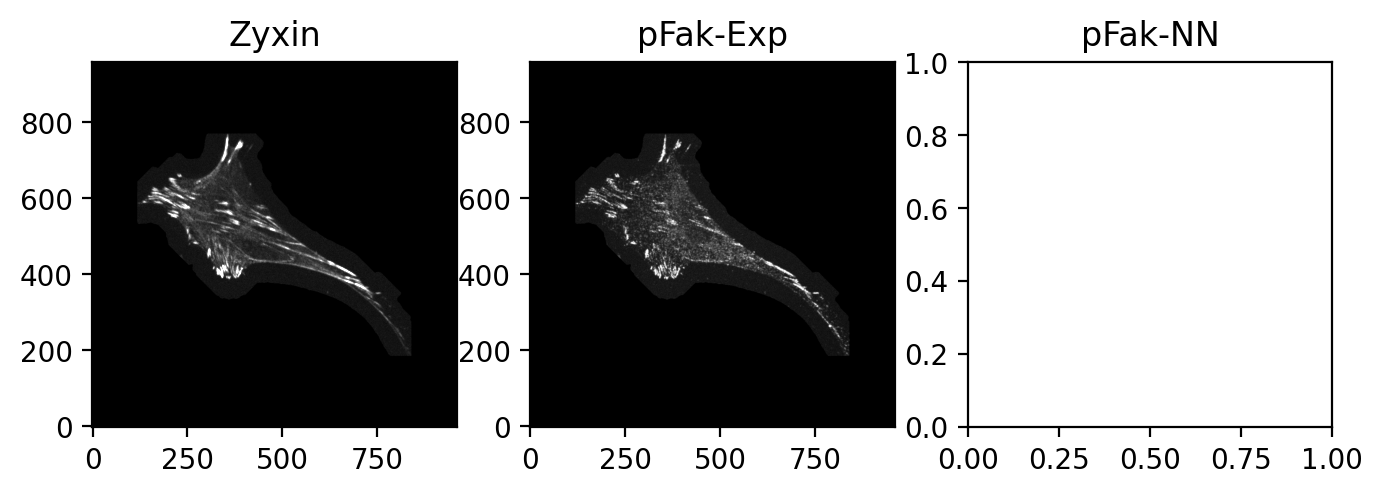

In [35]:
fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

# model = models['zyxin1']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_1'
frame = 5


idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)


ax[0].set_title('Zyxin')
ax[0].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=0.3, vmin=0)

ax[1].set_title('pFak-Exp')
ax[1].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)

ax[2].set_title('pFak-NN')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=1, vmin=0)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

### Performance on test cell

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(3*3, 3*1), dpi=200)

model = models['zyxin1']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_3'
frame = 250

idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)

ax[0].set_title('Paxillin')
ax[0].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)

ax[1].set_title('Zyxin-Exp')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)

ax[2].set_title('Zyxin-NN')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=1, vmin=0)


for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])